# Who is paying and NOT paying the loan?
    - by Jay Ko and Richard Petrie

"On my honor, as a student, I have neither given nor received unauthorized aid on this academic work."

## About dataset
<br/>
<div style="text-align:justify">: This dataset is directly from the website [Lending-Club-Loan-Data](https://www.kaggle.com/wendykan/lending-club-loan-data). According to its description, <u>this dataset contains completed load data for all all loans issued through the 2007-2015, including the current loan status and latest payment information. This data set is a matrix of about 890,000 observations and 75 columns</u><sup>[1]</sup>
[1]:https://www.kaggle.com/wendykan/lending-club-loan-data</div>

![](images/cash.jpg)

## Understanding data
<div style="text-align:justify">
<br/>
Not only to the merchandiser, but also to the loaner, getting money back is the most important part for their business. This data set observed almost 900,000 observation with variety factors such as `loan amount`, `funded amount`, `interest rate`, and `total payment` and etc. With this dataset, **we are trying to analysis who is most likely to pay back the loan and who is not**.</div>

## Data processing

In [1]:
# Import basic data science packages
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# A helper function that converts 
# ["a", "b", "a", "c"] into
# [1, 2, 1, 3]
def categorize(l):
    uniques = sorted(list(set(l)))
    return [uniques.index(x) + 1 for x in l]

In [2]:
df = pd.read_csv("data/loan.csv")
df.head(3)

/Users/Jay/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Initial drops. I'm fairly confident in not needing these.
df = df.drop(['url', 'desc', 'policy_code', 'last_pymnt_d', 'next_pymnt_d', 'earliest_cr_line', 'emp_title'], axis=1)
df = df.drop(['id', 'title', 'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp', 'zip_code'], axis=1)

In [4]:
# Booleanize
df['joint_application'] = [0 if x == "INDIVIDUAL" else 1 for x in df['application_type']]
df = df.drop(['application_type'], axis=1)

In [5]:
# Filters out "Does not meet credit policy" loan statuses
# Removes 2,749 records
# Additionally drops "issued" loans
df.groupby(['loan_status']).size()
df['loan_status_int'] = categorize(df['loan_status'])
df = pd.DataFrame(df[df['loan_status_int'] != 4])
df = pd.DataFrame(df[df['loan_status_int'] != 5])
df = pd.DataFrame(df[df['loan_status_int'] != 8])
df = df.drop(['loan_status_int'], axis=1)

df['loan_status'].unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)'], dtype=object)

In [6]:
# Need to drop or categorize object types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 876170 entries, 0 to 887378
Data columns (total 61 columns):
member_id                      876170 non-null int64
loan_amnt                      876170 non-null float64
funded_amnt                    876170 non-null float64
funded_amnt_inv                876170 non-null float64
term                           876170 non-null object
int_rate                       876170 non-null float64
installment                    876170 non-null float64
grade                          876170 non-null object
sub_grade                      876170 non-null object
emp_length                     876170 non-null object
home_ownership                 876170 non-null object
annual_inc                     876170 non-null float64
verification_status            876170 non-null object
issue_d                        876170 non-null object
loan_status                    876170 non-null object
pymnt_plan                     876170 non-null object
purpose             

In [7]:
# We may have to drop columns with nulls
df.isnull().any()

member_id                      False
loan_amnt                      False
funded_amnt                    False
funded_amnt_inv                False
term                           False
int_rate                       False
installment                    False
grade                          False
sub_grade                      False
emp_length                     False
home_ownership                 False
annual_inc                     False
verification_status            False
issue_d                        False
loan_status                    False
pymnt_plan                     False
purpose                        False
addr_state                     False
dti                            False
delinq_2yrs                    False
inq_last_6mths                 False
mths_since_last_delinq          True
mths_since_last_record          True
open_acc                       False
pub_rec                        False
revol_bal                      False
revol_util                      True
t

## Analysis

### A. Employement Length For Issued Loans

In [8]:
# make temporary dataframe in order to keep original dataframe
df_copy = df.copy()
df_copy["emp_length"] = ["0.5" if x == '< 1 year' else x for x in df_copy["emp_length"]]

# check employment length
df_copy.emp_length.unique()

array(['10+ years', '0.5', '1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '6 years', '2 years', '7 years', 'n/a'], dtype=object)

In [9]:
# Using regex to easy convert

import re
reg = re.compile(r'(\d+\.?\d?)')
t = []
for emp in df_copy.emp_length:
    value = reg.match(emp)
    t.append(float(value[0]) if value else 0)
df_copy['emp'] = t

# < 1 years is denoted by 0.5
# n/a is considered 0
# 10+ years is denoted 10 years

In [10]:
f = pd.value_counts(df_copy['emp']).to_frame().reset_index()
f.columns = ['type','count']

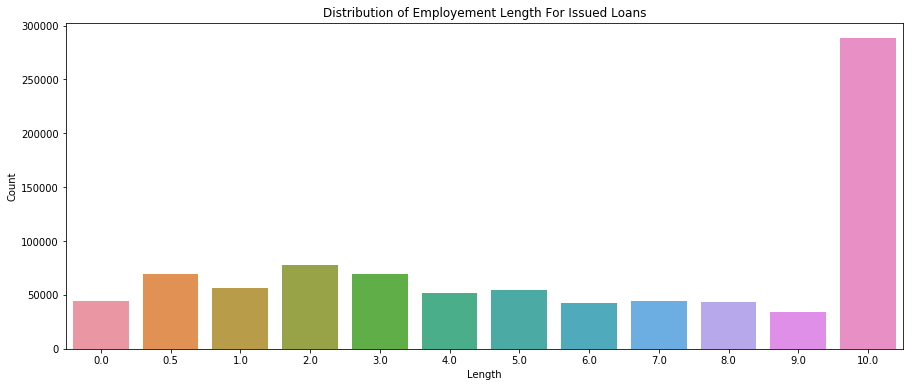

In [11]:
plt.subplots(figsize=(15,6))
sns.barplot(y='count', x='type', data=f)
plt.xlabel("Length")
plt.ylabel("Count")
plt.title("Distribution of Employement Length For Issued Loans")
plt.show()

### Summary
- People work for **10+ years** have the highest loan issue number(291,569) which is almost three times higher than second place(**0**, 115,430)

### B. Loan Status

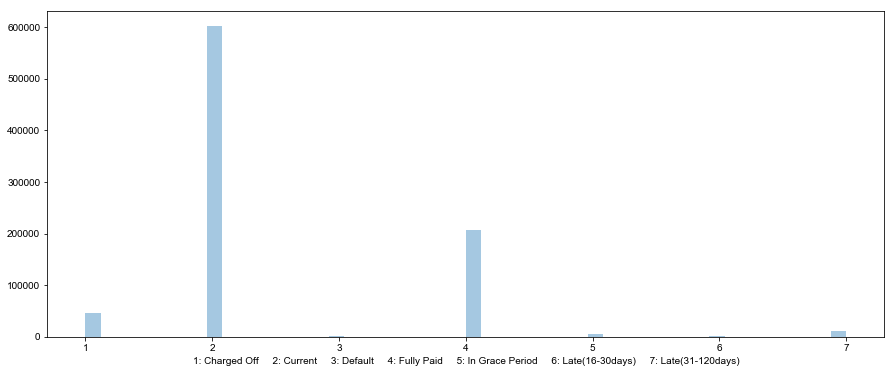

In [12]:
'''
legend = {6:("Late (16-30 days)",'b'),
          7:("Late (31-120 days)",'yellow'),
          5:("In Grace Period","k"),
          3:("Default",'magenta'),
          2:("Current", "orange"),
          1:("Charged Off","#512888"),
          4:("Fully Paid","#f7cfcf")}
'''
legend = "1: Charged Off     2: Current     3: Default     4: Fully Paid     5: In Grace Period     6: Late(16-30days)     7: Late(31-120days)"


plt.subplots(figsize=(15,6))

sns.set_context("paper", font_scale=2)
sns.set_style("white")
a = sns.distplot(categorize(df_copy["loan_status"]), kde=False)
a.set(xlabel=legend)
plt.legend()
plt.show()

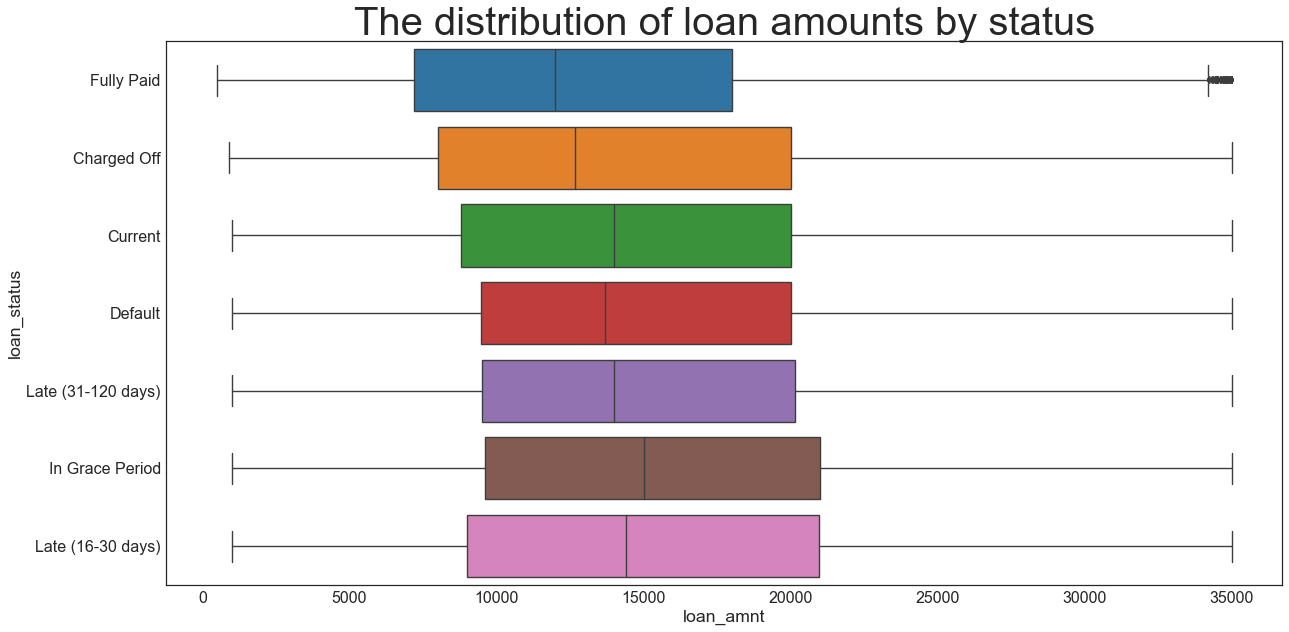

In [13]:
# Loan amount by its status
plt.subplots(figsize=(20,10))
plt.title("The distribution of loan amounts by status").set_size(40)
sns.boxplot(x="loan_amnt", y="loan_status", data=df_copy)

### Summary
- **Default** has the highest count among other **loan status**.
- **In Grace Period** and **Late(16~30 days)** have the highest loan amount and mean.

### C. Loan Amount Base on Grade

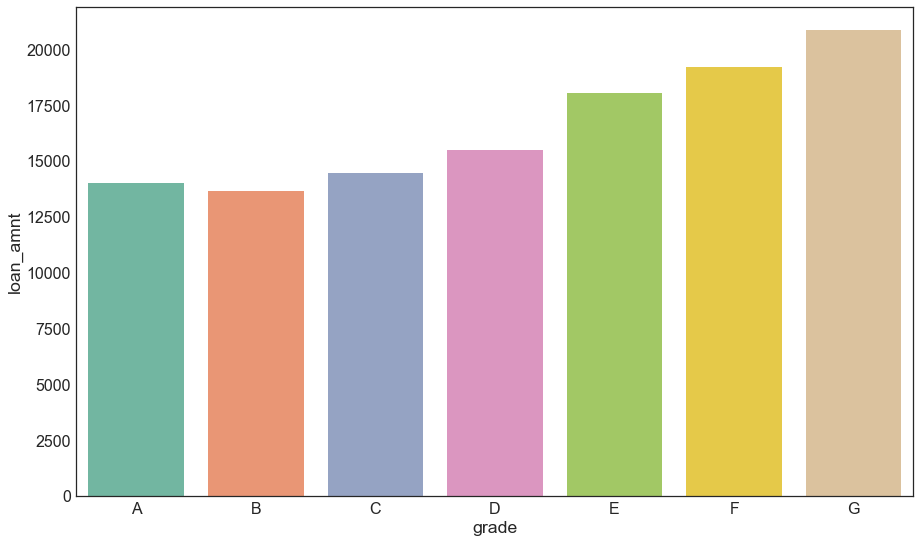

In [14]:
group = df_copy.groupby("grade").mean()
avg_loan = group['loan_amnt'].reset_index()
plt.subplots(figsize=(15,9))
sns.barplot(x='grade', y='loan_amnt', data=avg_loan, palette='Set2')

In [15]:
# clean plot
plt.clf()

### Summary
- The lower grade, the higher loan amount loan issued

### D. Region

In [16]:
# Import map visulization libraries
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [17]:
# create dataframe that holds values by state.
loan_amnt_by_state = df_copy.groupby(["addr_state"]).sum()["loan_amnt"]
df_region = loan_amnt_by_state.to_frame()
df_region["loan_amnt"] = df_region["loan_amnt"].map("{:,.0f}".format)
temp = []
for x in df_region["loan_amnt"]:
    a = int(x.replace(',', ''))
    temp.append(a)
df_region["loan_amnt"] = temp

# count number of loan issued
num_issued_loan = df_copy.groupby(["addr_state"]).count()["member_id"]
df_region["num_issued"] = num_issued_loan

# Average loan amount
avg_loan_amnt_by_state = []
for a,b in zip(df_region["loan_amnt"], df_region["num_issued"]):
    temp = int(a/b)
    avg_loan_amnt_by_state.append(temp)
df_region["avg_loan_amnt_by_state"] = avg_loan_amnt_by_state

# Average employment length
total_year = df_copy.groupby(["addr_state"]).sum()["emp"]
temp = []
for a, b in zip(total_year, df_region.num_issued):
    value = (a/b)
    value = "{0:.2f}".format(value)
    value = float(value)
    temp.append(value)
df_region["avg_emp_length_by_state"] = temp

In [18]:
# change index 
df_region_copy = df_region.copy()
addr_state = df_region_copy.index
addr_state.astype(str)

Index(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI',
       'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN',
       'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH',
       'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA',
       'WI', 'WV', 'WY'],
      dtype='object', name='addr_state')

In [19]:
df_region.index = list(range(1,52))
df_region["addr_state"] = addr_state
df_region.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51 entries, 1 to 51
Data columns (total 5 columns):
loan_amnt                  51 non-null int64
num_issued                 51 non-null int64
avg_loan_amnt_by_state     51 non-null int64
avg_emp_length_by_state    51 non-null float64
addr_state                 51 non-null object
dtypes: float64(1), int64(3), object(1)
memory usage: 2.4+ KB


In [20]:
# population by states from http://worldpopulationreview.com/states/

population = pd.read_csv("data/population.csv")
population.index = list(range(1,52))
#population.info()
df_region["population"] = population['2017 Population']



In [21]:
# Clean the df_region_copy memory 
del df_region_copy
df_region_copy = df_region.copy()

In [22]:
# Create another map
d = df_copy[df_copy["loan_status"].isin(["Late (16-30 days)","Late (31-120 days)","Default", "Charged Off", "Does not meet the credit policy. Status:Charged Off"])].groupby("addr_state").size()
d = d.to_frame()

e = pd.DataFrame([0],index=["ME"])
f = pd.concat([d,e])
f_copy = f.copy()
addr_state = f_copy.index
f.index = list(range(1,52))
f["addr_state"] = addr_state
f = f.sort_values(by="addr_state")
f.index = list(range(1,52))
df_region["num_default"] = f[0]

temp = []

for x, y in zip(df_region["num_default"], df_region["num_issued"].astype(int)):
    if x is not 0 and y is not 0:
        value = (x/y)
        value = "{0:.2f}".format(value)
        value = float(value)
        temp.append(value)
    else:
        temp.append(0)
df_region["default_rate"] = temp

# Average dti by the state
dti = df_copy.groupby("addr_state").agg([np.mean])["dti"]
dti.columns = ["dti"]
dti.index = list(range(1,52))
df_region = df_region.join(dti)

In [23]:
# plotly color setting
for col in df_region.columns:
    df_region[col] = df_region[col].astype(str)
    scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]


# create text column
df_region["text"] = df_region["addr_state"] + '<br>' + \
"Population: " + df_region["population"] + '<br>' + \
"Total loan amount ($ USD): " + df_region["loan_amnt"] + "<br>" + \
"Avg loan amount ($ USD): " + df_region["avg_loan_amnt_by_state"] + '<br>' + \
"Avg employment length (Years): " + df_region["avg_emp_length_by_state"] + "<br>" + \
"Default rate: " + df_region["default_rate"] + "<br>" + \
"DTI: " + df_region["dti"]


In [24]:
data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = df_region['addr_state'],
        z = df_region['avg_loan_amnt_by_state'], 
        locationmode = 'USA-states',
        text = df_region['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "$s USD")
        ) ]

layout = dict(
        title = 'Lending Club Loan<br> Average Loan By State',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict( data=data, layout=layout )
iplot( fig, filename='d3-cloropleth-map' )

### Summary
- Alaska has the highest **Average Loan Amount**.
- California has the highest **Total Loan Amount**.

- Iowa has the highest **Default rate**.
- Maine has the highest **DTI**.

### E. Interest Rate base on Grade

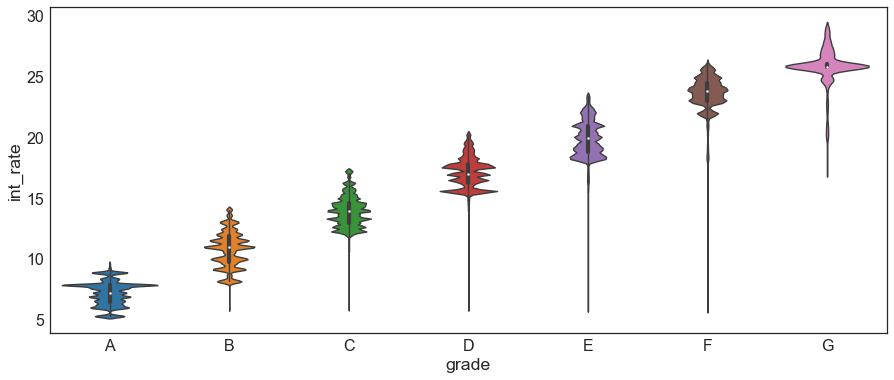

In [25]:
plt.subplots(figsize=(15,6))
sns.violinplot(x="grade", y="int_rate", data=df_copy, order="ABCDEFG")


### Summary
- Grade **A** has the lowest interest rate and mostly 7%
- Grade **G** has the highest interest rate and mostly 26%

### F. Exploratory Data

In [26]:
# create new dataset for exploratory analysis
df_exp = pd.DataFrame()
df_exp['annual_inc'] = df_copy['annual_inc']
df_exp['delinq_2yrs'] = df_copy['delinq_2yrs']
df_exp['dti'] = df_copy['dti']
df_exp['emp_length'] = categorize(df_copy['emp_length'])
df_exp['grade'] = categorize(df_copy['grade'])
df_exp['home_ownership'] = categorize(df_copy['home_ownership'])
df_exp['installment'] = df_copy['installment']
df_exp['int_rate'] = df_copy['int_rate']
df_exp['loan_amnt'] = df_copy['loan_amnt']
df_exp['loan_status'] = categorize(df_copy['loan_status'])
df_exp['purpose'] = categorize(df_copy['purpose'])
df_exp['sub_grade'] = categorize(df_copy['sub_grade'])
df_exp['term'] = categorize(df_copy['term'])
df_exp['acc_now_delinq'] = df_copy['acc_now_delinq']


#### F-1. Heatmap

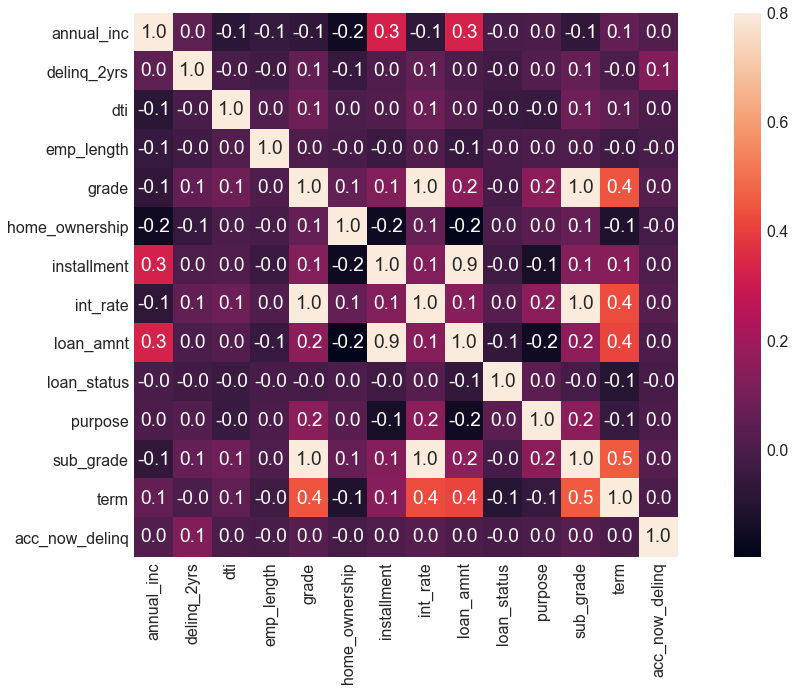

In [27]:
plt.figure(figsize=(20,10))
sns.set_context("paper", font_scale=2)
sns.heatmap(df_exp.corr(), vmax=.8, square=True, annot=True, fmt='.1f')

#### Summary
- **sub_grade** and **term** seem they have high correlation.
- Many factors(**grade**,**loan_amnt**,and **int_rate** seem they also have high correlation with **term**.
- It does not seem like **loan_status** is correlated to other factors

#### F-2 Statistical Testing

In [28]:
# import necessary libraries for statistical testing
from scipy import stats
from pandas.tools import plotting

Null Hypothesis
- There is no correlation between **grade** and **loan_status**.
- There is no correlation between **term** and **loan_status**.
- There is no correlation between **int_rate** and **loan_status**.


In [29]:
high_grade = df_exp[df_exp["grade"] < 4]["loan_status"]
low_grade = df_exp[df_exp["grade"] >= 4]["loan_status"]
two_samples = stats.ttest_ind(high_grade, low_grade)
print("The t-statistic is %.3f and the p-value is %.3f" % two_samples)

The t-statistic is 7.568 and the p-value is 0.000


- With low p-value, we can reject null hypothesis. It indicates there is correlation between **grade** and **loan_status**

In [30]:
shorter_term = df_exp[df_exp.term == 1]["loan_status"]
longer_term = df_exp[df_exp.term == 2]["loan_status"]
two_samples = stats.ttest_ind(shorter_term, longer_term)
print("The t-statistic is %.3f and the p-value is %.3f" % two_samples)

The t-statistic is 86.206 and the p-value is 0.000


- With low p-value, we can reject null hypothesis. It indicates there is correlation between **term** and **loan_status**

In [31]:
low_int_rate = df_exp[df_exp["int_rate"] < 16.00]["loan_status"]
high_int_rate = df_exp[df_exp["int_rate"] >= 16.00]["loan_status"]
two_samples = stats.ttest_ind(low_int_rate, high_int_rate)
print("The t-statistic is %.3f and the p-value is %.3f" % two_samples)

The t-statistic is -7.996 and the p-value is 0.000


- With low p-value, we can reject null hypothesis. It indicates there is correlation between **int_rate** and **loan_status**

### Summary
- On the simple **heatmap**, it is difficult to find correlation between **loan_status** and other factors
- However, on the statistical analysis, we also cannot ignore the heatmap result base on **null hypothesis analysis**
- We need to further analysis

![](images/statistics.jpg)

# Machine Learning
TODO Explain that we want predictions

In [32]:
from sklearn import metrics, svm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import OneSidedSelection

In [33]:
# Data set up
# TODO Make clean and normalize data
# TODO balance data
df_ml = pd.DataFrame()
df_ml['annual_inc'] = df['annual_inc']
df_ml['delinq_2yrs'] = df['delinq_2yrs']
df_ml['dti'] = df['dti']
df_ml['emp_length'] = categorize(df['emp_length'])
#df_ml['fico_range_high'] = df['fico_range_high']
#df_ml['fico_range_low'] = df['fico_range_low']
df_ml['grade'] = categorize(df['grade'])
df_ml['home_ownership'] = categorize(df['home_ownership'])
df_ml['installment'] = df['installment']
df_ml['int_rate'] = df['int_rate']
df_ml['loan_amnt'] = df['loan_amnt']
df_ml['loan_status'] = categorize(df['loan_status'])
#df_ml['mnths_since_last_delinq'] = df['mnths_since_last_delinq']
#df_ml['mnths_since_last_major_derog'] = df['mnths_since_last_major_derog']
df_ml['purpose'] = categorize(df['purpose'])
df_ml['sub_grade'] = categorize(df['sub_grade'])
df_ml['term'] = categorize(df['term'])
#df_ml['all_util'] = df['all_util']
df_ml['acc_now_delinq'] = df['acc_now_delinq']
#df_ml['tot_cur_bal'] = df['tot_cur_bal']
#df_ml['int_rate'] = [int(round(x)) for x in df['int_rate']]
#df_ml['int_rate'].unique()

In [34]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 876170 entries, 0 to 887378
Data columns (total 14 columns):
annual_inc        876170 non-null float64
delinq_2yrs       876170 non-null float64
dti               876170 non-null float64
emp_length        876170 non-null int64
grade             876170 non-null int64
home_ownership    876170 non-null int64
installment       876170 non-null float64
int_rate          876170 non-null float64
loan_amnt         876170 non-null float64
loan_status       876170 non-null int64
purpose           876170 non-null int64
sub_grade         876170 non-null int64
term              876170 non-null int64
acc_now_delinq    876170 non-null float64
dtypes: float64(7), int64(7)
memory usage: 100.3 MB


In [35]:
df_ml.isnull().any()

annual_inc        False
delinq_2yrs       False
dti               False
emp_length        False
grade             False
home_ownership    False
installment       False
int_rate          False
loan_amnt         False
loan_status       False
purpose           False
sub_grade         False
term              False
acc_now_delinq    False
dtype: bool

In [36]:
y = df_ml['loan_status']
X = df_ml.drop(['loan_status'], axis=1)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

oss = OneSidedSelection()
X_resampled, y_resampled = oss.fit_sample(X, y)
#X_resampled_train, X_resampled_test, y_resampled_train, y_resampled_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=1)

/Users/Jay/anaconda/lib/python3.6/site-packages/imblearn/under_sampling/prototype_selection/one_sided_selection.py:197: DeprecationWarning:

in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.

/Users/Jay/anaconda/lib/python3.6/site-packages/imblearn/under_sampling/prototype_selection/one_sided_selection.py:197: DeprecationWarning:

in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.

/Users/Jay/anaconda/lib/python3.6/site-packages/imblearn/under_sampling/prototype_selection/one_sided_selection.py:197: DeprecationWarning:

in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.

/Users/Jay/anaconda/lib/python3.6/site-packages/imblearn/under_sampling/prototype_selection/one_sided_selection.py:197: DeprecationWarning:

in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.

/Users/Jay/anaconda/lib/python3.

In [38]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

print("Decision tree - Normal data set")
print(metrics.accuracy_score(y_test, dt.predict(X_test)))
#print(metrics.confusion_matrix(y_test, dt.predict(X_test)))


dt = DecisionTreeClassifier()
dt.fit(X_resampled, y_resampled)
print("Decision tree - Imbalanced lean -One Sided Selection")
print(metrics.accuracy_score(y, dt.predict(X)))
#print(metrics.confusion_matrix(y, dt.predict(X)))

Decision tree - Normal data set
0.651410875363
Decision tree - Imbalanced lean -One Sided Selection
0.890019060228


In [39]:
dt = DecisionTreeClassifier(max_depth=5, max_features=5)
dt.fit(X_train, y_train)

print(metrics.accuracy_score(y_test, dt.predict(X_test)))
#print(metrics.confusion_matrix(y_test, dt.predict(X_test)))

dt = DecisionTreeClassifier(max_depth=5, max_features=5)
dt.fit(X_resampled, y_resampled)

print(metrics.accuracy_score(y, dt.predict(X)))
#print(metrics.confusion_matrix(y, dt.predict(X)))

0.698547846499
0.700661971992


In [40]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

print("Random Forest - Normal data set")
print(metrics.accuracy_score(y_test, clf.predict(X_test)))
#print(metrics.confusion_matrix(y_test, clf.predict(X_test)))
print("\n")
clf = RandomForestClassifier()
clf.fit(X_resampled, y_resampled)

print("Random Forest - Imbalanced learn - One-sided Selection")
print(metrics.accuracy_score(y, clf.predict(X)))
#print(metrics.confusion_matrix(y, clf.predict(X)))

Random Forest - Normal data set
0.729557810318


Random Forest - Imbalanced learn - One-sided Selection
0.881010534485
